### Should AIFS Hedge with Options and Forwards?


$$
\Pi = \text{Realised profit in USD},\quad
N = \text{Realised volume},\quad
N_H = \text{Expected volume},\quad
r_{\text{usd}} = \text{Revenue/student},\quad \\
\alpha = \text{Fraction hedged with options},\quad
c_{\text{eur}} = \text{Cost/student},\quad
F_1 = \text{Forward rate / option strike},\quad \\
\phi = \text{Option fee fraction},\quad
S_1 = \text{Realised spot},\quad
C_{\text{opt}} = \text{Option payoff}, \quad
k = \text{Cover ratio}
$$


$$ 
C_{\text{opt}}  = \alpha k N_H c_{\text{eur}} (\max(S_1 - F_1, 0) - S_1) 
$$

$$
\Pi =
\underbrace{N \cdot r_{\text{usd}}}_{\text{Revenue}}
-
\underbrace{(1-\alpha) k N_H \, c_{\text{eur}} \, F_1}_{\text{Forward Cost}}
-
\underbrace{\alpha k N_H \, c_{\text{eur}} \, F_1 \, \phi}_{\text{Option Premium}}
-
\underbrace{(N - k N_H) \, c_{\text{eur}} \, S_1}_{\text{Unhedged Costs}}
+
\underbrace{C_{\text{opt}}}_{\text{Option Outcome}}
$$


Our primary goal is to construct a hedge that keeps operating profit positive across all extreme scenarios while simultaneously maximising expected profit according to the probability distributions of FX and volume. The variables we are solving for are the cover percentage $k \in (0,1)$ and the options split $\alpha \in (0,1)$. We outline a general approach for probabilistic operating profit maximisation that determines the optimal $\alpha$. Several parameter assumptions are taken from the paper and slides, but the methodology applies equally with different values.

It is important to note that the parameter with the greatest influence on our optimisation is the extreme scenario bounds for volume. Management should therefore be confident in these numbers and set them conservatively; in our case, we assume they are. This is because exceeding either bound could quickly lead to negative operating profit, which the hedge is designed to prevent entirely.

#### Estimating Volume Risk PDFs
We consider the High School and College divisions separately because they have different risk profiles with regard to volume, leading to different probability distributions which we manually construct. Based on the limited data available for volume forecasts, the High School division is assumed to face the same risk observed historically with four extreme events over the past 25 years (16%), which led to up to 60% lower volume than expected. For the College division, less information is available, but volumes are generally more stable, resulting in lower variance.

For the High School division, the expected volume is 25,000 students, mostly between 20,000 and 30,000, with a 16% chance of an extreme low of 10,000. The PDF consists of a core Gaussian centered at 25,000 and a narrow spike at 10,000. For the College division, the PDF is a single Gaussian centered at 5,000, with most outcomes between 4,000 and 6,000, reflecting the lower variability (±20%) described in the paper. The two PDFs are plotted below.

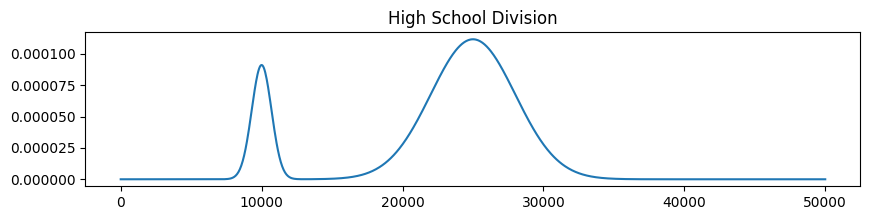

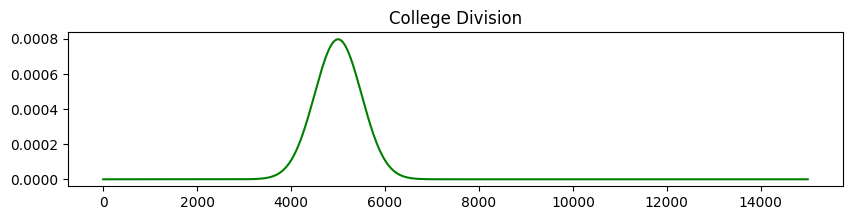

In [ ]:
# Code to define and plot the student volume PDF's 
import numpy as np
import pandas as pd
from scipy.stats import norm

def get_augmented_volume_pdf(
        center=25000, core_scale=3000, has_spike=True, spike_loc=10000, spike_prob=0.16, x_max=50000
    ):
    x_vals = np.linspace(0, x_max, 1_000)
    
    # Calculate Core Probability
    core_prob = 1.0 - (spike_prob if has_spike else 0)
    
    # Generate Normal Core
    core_pdf = norm.pdf(x_vals, loc=center, scale=core_scale)
    core_pdf /= np.trapezoid(core_pdf, x_vals) # Ensure core sums to 1 before weighting
    
    pdf_vals = core_pdf * core_prob
    
    # Add the spike if applicable
    if has_spike:
        # Spread of 700 keeps the spike narrow but visible
        spread = 700 
        spike_pdf = (spike_prob / (spread * np.sqrt(2 * np.pi))) * \
                    np.exp(-0.5 * ((x_vals - spike_loc) / spread)**2)
        pdf_vals += spike_pdf

    # Normalisation
    pdf_vals /= np.trapezoid(pdf_vals, x_vals)

    return x_vals, pdf_vals

# High School Division: 16% chance of the 10k shock mentioned in the paper
hs_range, hs_pdf = get_augmented_volume_pdf(
    center=25000, core_scale=3000, has_spike=True, spike_loc=10000, spike_prob=0.16
)

# College Division: Higher center, lower variance, no catastrophic spikes
coll_range, coll_pdf = get_augmented_volume_pdf(
    center=5000, core_scale=500, has_spike=False, x_max=15000
)

pd.Series(hs_pdf, index=hs_range).plot(title="High School Division", figsize=(10, 2))
plt.show()
pd.Series(coll_pdf, index=coll_range).plot(title="College Division", figsize=(10, 2), color='green')
plt.show()

#### Estimating the Currency Exchange PDF
We restrict the optimisation to the EUR/USD exchange rate, since the same methodology applies to other currencies and including them would add unnecessary dimensionality. We construct a two-year ahead exchange rate PDF starting on 1 July 2004, using data going back to 1990, which corresponds to the date sales begin and prices are set. Hedging is assumed to occur quarterly over the year leading up to price setting, with each hedge having a two-year maturity to reflect that Euro costs are incurred in the year following sales, when the trips take place. This periodic hedging spreads risk over time, since sales occur continuously throughout the year and the associated Euro costs are similarly spread over the following year. From the paper, we use a forward rate of 1.22 USD/EUR, which is consistent with the spot price of 1.216 USD/EUR on 2004-07-01.

To estimate the PDF, we first convert EUR/USD prices into daily log returns, then fit a GARCH(1,1) model with Student-t distributed errors to capture time-varying volatility and FX shocks. The model is used to aggregate daily variances over a 2-year horizon, from which the total mean and volatility of returns are forecasted. A Student-t return distribution is then constructed using these parameters and finally transformed into a price distribution.

1. Convert historical to daily log returns for EUR/USD spot price
$$r_t = \ln \frac{S_t}{S_{t-1}}$$

2. Fit GARCH(1,1)-t to model time varying volatility with fat tails (Smaller $\nu$ -> heavier tails -> higher probability of extreme FX returns). Model fitting returns: $\omega, \alpha, \beta, \nu, \mu$
$$r_t = \mu + \epsilon_t, \quad \epsilon_t = \sigma_t z_t, \quad z_t \sim t_\nu$$
$$\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2$$

3. Forecast k-day ahead variance iteratively over 2 years of days
$$\text{Var}_{504\text{-day}} = \sum_{i=1}^{504} \sigma_{t+i}^2$$

4. Compute total horizon mean & std dev
$$\mu_{504} = \mu \cdot 504, \quad \sigma_{504} = \sqrt{\text{Var}_{504\text{-day}}}$$

5. Construct 2-year return PDF, Student-t scaled for variance
$$f_R(x) = \frac{1}{\sigma_{504}} t_\nu\Big(\frac{x}{\sigma_{504}} \sqrt{\frac{\nu-2}{\nu}}\Big)$$

6. Convert log returns PDF to price PDF
$$S = S_0 e^x, \quad f_S(S) = \frac{f_R(x)}{S}$$

Date end:  2004-07-01
Spot EUR/USD:  1.216
Forward EUR/USD:  1.22


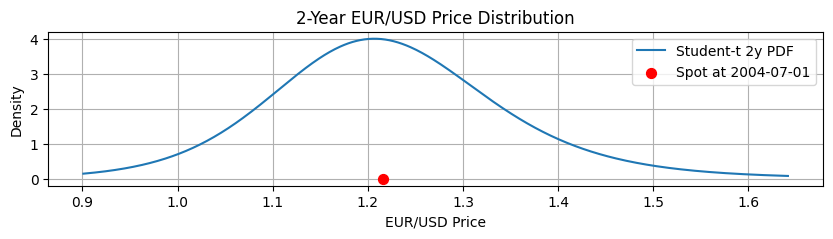

In [ ]:
# Code to define and plot the EUR/USD 2-year ahead PDF
import numpy as np
import pandas as pd
import lseg.data as ld
from arch import arch_model
from scipy.stats import t, norm
import matplotlib.pyplot as plt


ld.open_session()
HEDGE_PERIOD = 252*2
date_end = "2004-07-01"
F1 = 1.22 # Forwards price
fx = ld.get_history(universe="EUR=", fields=["MID_PRICE"], start="1990-01-01", end=date_end
        ).rename(columns={"MID_PRICE": "EURUSD=X"}) # Historical EUR/USD up to hedge date '2004-07-01'
S0 = float(fx["EURUSD=X"].iloc[-1]) # Spot EUR/USD

def eur_usd_fx_pdf():
    fx_returns = np.log(fx / fx.shift(1)).dropna()*100

    # Fit GARCH(1,1) model using maximum likely hood
    res = arch_model(fx_returns, vol='Garch', p=1, q=1, dist='t', mean='constant').fit(disp='off')

    # Multi-step k-day ahead variance (2 year)
    omega, alpha, beta = res.params['omega'], res.params['alpha[1]'], res.params['beta[1]']
    conditional_var = res.conditional_volatility.iloc[-1]**2
    final_residual = res.resid.iloc[-1]**2

    # Iterative forecast of daily variance solution k-day's ahead
    var_2y = 0
    for _ in range(HEDGE_PERIOD):
        conditional_var = omega + alpha * final_residual + beta * conditional_var
        var_2y += conditional_var
    var_2y /= 100**2  # undo scaling

    # 2-year return PDF
    mu = res.params['mu'] / 100 * HEDGE_PERIOD  # annualized mean
    sigma = np.sqrt(var_2y)

    # Student-t df (v) and scaling for actual variance
    v = res.params['nu']
    x = np.linspace(-0.3, 0.3, 500) # Possible range of log returns
    pdf_t = t.pdf(x / sigma * np.sqrt((v-2)/v), df=v) / sigma # corresponding probabilies

    # Convert to price PDF
    price_range = S0 * np.exp(x)
    pdf_price_t = pdf_t / price_range

    print("Date end: ", date_end)
    print("Spot EUR/USD: ", round(S0, 3))
    print("Forward EUR/USD: ", round(float(F1), 3))
    return price_range, pdf_price_t

# Plot
def plot(price_range, fx_pdf):
    plt.figure(figsize=(10, 2))
    plt.plot(price_range, fx_pdf, label='Student-t 2y PDF')
    plt.scatter(S0, 0, color='red', s=50, zorder=5, label=f'Spot at {date_end}')
    plt.title("2-Year EUR/USD Price Distribution")
    plt.xlabel("EUR/USD Price")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()

fx_range, fx_pdf = eur_usd_fx_pdf()
plot(fx_range, fx_pdf)

#### Parameter Optimisation
To determine the optimal cover $k$ and option split $\alpha$, we set up an optimisation problem with the objective of maximising operating profit. We assume a cost per student of €1,000, revenue per student of $1,350, and an at-the-money 2-year call option costing 5% of the hedged contract value. The operating profit equation is defined as follows.

$$
\Pi = \text{Realised profit in USD},\quad
N = \text{Realised volume},\quad
N_H = \text{Expected volume},\quad
r_{\text{usd}} = \text{Revenue/student},\quad \\
\alpha = \text{Fraction hedged with options},\quad
c_{\text{eur}} = \text{Cost/student},\quad
F_1 = \text{Forward rate / option strike},\quad \\
\phi = \text{Option fee fraction},\quad
S_1 = \text{Realised spot},\quad
C_{\text{opt}} = \text{Option payoff}, \quad
k = \text{Cover ratio}
$$


$$ 
C_{\text{opt}}  = \alpha k N_H c_{\text{eur}} (\max(S_1 - F_1, 0) - S_1) 
$$

$$
\Pi =
\underbrace{N \cdot r_{\text{usd}}}_{\text{Revenue}}
-
\underbrace{(1-\alpha) k N_H \, c_{\text{eur}} \, F_1}_{\text{Forward Cost}}
-
\underbrace{\alpha k N_H \, c_{\text{eur}} \, F_1 \, \phi}_{\text{Option Premium}}
-
\underbrace{(N - k N_H) \, c_{\text{eur}} \, S_1}_{\text{Unhedged Costs}}
+
\underbrace{C_{\text{opt}}}_{\text{Option Outcome}}
$$

Using this equation, we evaluate expected profit over the full range of volume and FX scenarios, while enforcing a hard constraint that any strategy producing losses in extreme volume cases is rejected by assigning negative infinity utility. We optimise using the Powell method, which ideal for objectives with abrupt jumps induced by the feasibility constraint, ensuring that only non-negative profit strategies are considered. The results show that for the High School Division the optimal hedge covers 100% of expected volume ($k=1.0$) with an options weight of $\alpha=0.54$, implying a 54% options and 46% forwards split on 25,000 students. For the College Division, the optimal solution is also full coverage ($k=1.0$) but entirely with forwards ($\alpha=0.0$) on an expected volume of 5,000 students. Additionally, the expected probability weighted operating profit for the High School and College Divisions is €110.50 and €130, respectively, based on the initial assumptions for cost and revenue per student.

In [ ]:
# Code to run the parameter optimisation to maximise opperating profit
from scipy.optimize import minimize_scalar, minimize

REVENUE_PER_STUDENT_USD = 1350
COST_PER_STUDENT_EUR = 1000
OPTION_FEE = 0.05


def pdf_to_midpoint_prob(x, pdf):
    """Convert a PDF defined on a grid into midpoint probabilities"""
    x, pdf = np.asarray(x), np.asarray(pdf)
    mid = 0.5 * (x[:-1] + x[1:])
    dx = np.diff(x)
    pdf_mid = 0.5 * (pdf[:-1] + pdf[1:])
    p = pdf_mid * dx
    p /= p.sum()
    return mid, p

def profit(spot_eur_usd, students_total, cover, options_split, expected_volume):
    """Calculate the operating profit for the given real world scenario"""
    split_fwds = (1 - options_split)
    students_hedged = expected_volume * cover

    revenue_usd = students_total * REVENUE_PER_STUDENT_USD
    hedged_eur = students_hedged * COST_PER_STUDENT_EUR 

    fwd_cost = split_fwds * hedged_eur * F1
    option_cost = options_split * hedged_eur * F1 * OPTION_FEE
    unhedged_costs = (students_total - students_hedged) * COST_PER_STUDENT_EUR * spot_eur_usd

    option_hedged_eur_spend = options_split * hedged_eur * spot_eur_usd
    option_payoff = options_split * hedged_eur * np.maximum(spot_eur_usd - F1, 0) - option_hedged_eur_spend

    operating_profit = revenue_usd - fwd_cost - option_cost - unhedged_costs + option_payoff
    return operating_profit

def expected_profit_constrained(
        options_split, vol_mid, vol_prob, fx_mid, fx_prob, expected_v, low_v, high_v, cover=1.0
    ):
    """Expected profit over the combination of volumes and fx rates, assuming they are not correlated"""
    profit_matrix = np.zeros((len(vol_mid), len(fx_mid)))
    min_profit_in_constraint = np.inf

    for i, v in enumerate(vol_mid):
        profits_fx = []
        for j, s in enumerate(fx_mid):
            p = profit(
                spot_eur_usd=s,
                students_total=v,
                cover=cover,
                options_split=options_split,
                expected_volume=expected_v
            )
            profits_fx.append(p)
            profit_matrix[i, j] = p

        # Constraint that profit is non negative within the extreme bounds
        if (low_v <= v <= high_v):
            min_profit_in_constraint = min(min_profit_in_constraint, min(profits_fx))

    # Hard constraint on negative profit within volume bounds
    if min_profit_in_constraint < 0:
        return -np.inf

    # Expected profit
    exp_profit = np.sum(profit_matrix * np.outer(vol_prob, fx_prob))
    return exp_profit

# FX (EUR/USD) midpoint/probabilities
fx_mid, fx_p = pdf_to_midpoint_prob(fx_range, fx_pdf)

# Volume midpoint/probabilities
hs_mid, hs_p  = pdf_to_midpoint_prob(hs_range, hs_pdf)
coll_mid, coll_p = pdf_to_midpoint_prob(coll_range, coll_pdf)

### Alpha for Highschool 

In [64]:
# Highschool Optimisation for alpha
hs_result = minimize_scalar(
    lambda alpha: -expected_profit_constrained(
        options_split=alpha, vol_mid=hs_mid, vol_prob=hs_p, fx_mid=fx_mid, fx_prob=fx_p, 
        expected_v=25_000, low_v=10_000, high_v=30_000
    ), bounds=(0, 1), method='bounded'
)
print(f"Highschool Division\n\tOptimal Options Split α: {hs_result.x:.2%}")
print(f"\tExpected Profit per Student: ${-hs_result.fun/25_000:,.2f}")

/Users/dcunning/Code/Python/imperial/.venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:2358:RuntimeWarning: invalid value encountered in scalar subtract
/Users/dcunning/Code/Python/imperial/.venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:2359:RuntimeWarning: invalid value encountered in scalar subtract


Highschool Division
	Optimal Options Split α: 53.78%
	Expected Profit per Student: $110.48


### Alpha for College 

In [65]:
# College Optimisation for alpha
coll_result = minimize_scalar(
    lambda alpha: -expected_profit_constrained(
        options_split=alpha, vol_mid=coll_mid, vol_prob=coll_p, fx_mid=fx_mid, fx_prob=fx_p, 
        expected_v=5_000, low_v=4_000, high_v=6_000
    ), bounds=(0, 1), method='bounded'
)
print(f"College Division\n\tOptimal Options Split α: {coll_result.x:.2%}")
print(f"\tExpected Profit per Student: ${-coll_result.fun/5_000:,.2f}")

College Division
	Optimal Options Split α: 0.00%
	Expected Profit per Student: $130.00


### Cover& alpha for Highschool 

In [66]:
result = minimize(
    lambda x: -expected_profit_constrained(
        options_split=x[1], vol_mid=hs_mid, vol_prob=hs_p, fx_mid=fx_mid, fx_prob=fx_p, 
        expected_v=25_000, low_v=10_000, high_v=30_000, cover=x[0]
    ),
    x0=[1.0, 0.05],
    bounds=[(0,1), (0,1)],
    method='Powell'
)
opt_cover, opt_alpha = result.x
print(f"Highschool Division\n\tOptimal Cover: {opt_cover:.2%}\n\tOptimal Options Split α: {opt_alpha:.2%}")
print(f"\tExpected Profit per Student: ${-result.fun/25_000:,.2f}")


Highschool Division
	Optimal Cover: 99.99%
	Optimal Options Split α: 53.77%
	Expected Profit per Student: $110.48


### Cover & alpha for College 

In [68]:
result = minimize(
    lambda x: -expected_profit_constrained(
        options_split=x[1], vol_mid=coll_mid, vol_prob=coll_p, fx_mid=fx_mid, fx_prob=fx_p, 
        expected_v=5_000, low_v=4_000, high_v=6_000, cover=x[0]
    ),
    x0=[1.0, 0.05],
    bounds=[(0,1), (0,1)],
    method='Powell'
)
opt_cover, opt_alpha = result.x
print(f"College Division\n\tOptimal Cover: {opt_cover:.2%}\n\tOptimal Options Split α: {opt_alpha:.2%}")
print(f"\tExpected Profit per Student: ${-result.fun/5_000:,.2f}")


College Division
	Optimal Cover: 99.99%
	Optimal Options Split α: 0.00%
	Expected Profit per Student: $130.00
